In [1]:
!pip install mne
!pip install seaborn

# Install a version of scikit-learn that works with MNE
!pip install scikit-learn==1.5.2



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# --- UTILITY: PRINT DATASET MENU ---

def print_eegmmidb_structure():
    print("=== PhysioNet EEGMMIDB Dataset Structure ===")
    print("Subject performs different tasks in different 'Runs'.")
    print("-" * 50)
    
    # Standard mapping for PhysioNet EEG Motor Imagery Dataset
    # derived from: https://physionet.org/content/eegmmidb/1.0.0/
    runs = {
        1:  "Baseline: Eyes Open",
        2:  "Baseline: Eyes Closed",
        3:  "Execute Motion: Left vs Right Hand",
        4:  "Imagine Motion: Left vs Right Hand (Task 2)",
        5:  "Execute Motion: Both Fists vs Both Feet",
        6:  "Imagine Motion: Both Fists vs Both Feet (Task 4)",
        7:  "Execute Motion: Left vs Right Hand",
        8:  "Imagine Motion: Left vs Right Hand (Task 2)",
        9:  "Execute Motion: Both Fists vs Both Feet",
        10: "Imagine Motion: Both Fists vs Both Feet (Task 4)",
        11: "Execute Motion: Left vs Right Hand",
        12: "Imagine Motion: Left vs Right Hand (Task 2)",
        13: "Execute Motion: Both Fists vs Both Feet",
        14: "Imagine Motion: Both Fists vs Both Feet (Task 4)"
    }

    for run_id, description in runs.items():
        prefix = "[SELECTED] " if run_id in [6, 10, 14] else "           "
        print(f"{prefix}Run {run_id:02d}: {description}")
    
    print("-" * 50)
    print("Project Requirement: 'Discriminating imagine opening and closing both fists or both feet' ")
    print("Conclusion: You should use Runs 6, 10, and 14.")

print_eegmmidb_structure()

=== PhysioNet EEGMMIDB Dataset Structure ===
Subject performs different tasks in different 'Runs'.
--------------------------------------------------
           Run 01: Baseline: Eyes Open
           Run 02: Baseline: Eyes Closed
           Run 03: Execute Motion: Left vs Right Hand
           Run 04: Imagine Motion: Left vs Right Hand (Task 2)
           Run 05: Execute Motion: Both Fists vs Both Feet
[SELECTED] Run 06: Imagine Motion: Both Fists vs Both Feet (Task 4)
           Run 07: Execute Motion: Left vs Right Hand
           Run 08: Imagine Motion: Left vs Right Hand (Task 2)
           Run 09: Execute Motion: Both Fists vs Both Feet
[SELECTED] Run 10: Imagine Motion: Both Fists vs Both Feet (Task 4)
           Run 11: Execute Motion: Left vs Right Hand
           Run 12: Imagine Motion: Left vs Right Hand (Task 2)
           Run 13: Execute Motion: Both Fists vs Both Feet
[SELECTED] Run 14: Imagine Motion: Both Fists vs Both Feet (Task 4)
--------------------------------------

In [3]:
import mne
from mne.datasets import eegbci

# Load just one run to inspect it
test_file = eegbci.load_data(1, [6], update_path=False)[0]
raw_test = mne.io.read_raw_edf(test_file, preload=True, verbose=False)

print("\n=== LOADED DATA DETAILS ===")
print(raw_test.info)  # Prints channel names, sampling rate (sfreq), etc.
print("\n=== ANNOTATIONS (Markers) ===")
print(raw_test.annotations) # Prints the triggers (T0, T1, T2)


=== LOADED DATA DETAILS ===
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>

=== ANNOTATIONS (Markers) ===
<Annotations | 30 segments: T0 (15), T1 (7), T2 (8)>


In [4]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import tfr_morlet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# PRO TIP: Set a professional plotting theme
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (10, 6)

print("Environment configured for analysis.")

Environment configured for analysis.


In [5]:
# ---  ROBUST DATA LOADING ---
subject = 1
runs = [6, 10]  # Task 4: Fists vs Feet

# Load Data
files = eegbci.load_data(subject, runs, update_path=False, verbose=False)
raws = [mne.io.read_raw_edf(f, preload=True, verbose=False) for f in files]
raw = mne.concatenate_raws(raws)

# Standardize and Pick EEG
eegbci.standardize(raw)
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage)
raw.pick(['eeg'], exclude='bads')

# --- 2. PREPROCESSING (FILTERING) ---
# Filter 7-30Hz (Mu/Beta bands)
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge', verbose=False)
raw.resample(128) # Downsample to 128Hz
print(f"Data Loaded: {len(raw.ch_names)} Channels, {raw.times[-1]:.1f} Seconds")

Data Loaded: 64 Channels, 250.0 Seconds


Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Calculating Time-Frequency Representation (Wait a moment)...
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Plotting Event-Related Desynchronization (ERD)...
Applying baseline correction (mode: logratio)


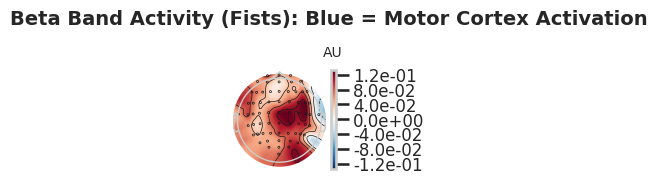

INTERPRETATION:
- Blue areas indicate 'Desynchronization' (Brain active/processing).
- You should see blue blobs over C3 and C4 (the Left/Right Motor Cortex).


In [6]:
# VISUALIZATION: TIME-FREQUENCY ANALYSIS 

# 1. Create specific epochs for visualization (include pre-stimulus baseline)
# We use a copy of the events to avoid messing up the main processing
events, event_id = mne.events_from_annotations(raw)
tmin, tmax = -1, 4
epochs_vis = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, 
                        baseline=(None, 0), preload=True, verbose=False)
epochs_vis = epochs_vis['T1'] # Look at "Fists" specifically

# 2. Define frequencies (Mu and Beta bands: 6-35 Hz)
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.  # Variable time window for accuracy

# 3. Calculate Power (Morlet Wavelet)
print("Calculating Time-Frequency Representation (Wait a moment)...")
power = tfr_morlet(epochs_vis, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                   return_itc=False, decim=3, n_jobs=1)

# 4. Plot the Topology (ERD - Event Related Desynchronization)
print("Plotting Event-Related Desynchronization (ERD)...")

# FIX: Removed 'title' argument inside the function
# We also ensure 'baseline' is applied here to see the CHANGE in energy
fig = power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=13, fmax=30,
                         baseline=(-1, 0), mode='logratio', show=False)

# Add title manually using Matplotlib (Works on all MNE versions)
plt.suptitle('Beta Band Activity (Fists): Blue = Motor Cortex Activation', fontsize=14, fontweight='bold')
plt.show()

print("INTERPRETATION:")
print("- Blue areas indicate 'Desynchronization' (Brain active/processing).")
print("- You should see blue blobs over C3 and C4 (the Left/Right Motor Cortex).")

In [7]:
# --- EMERGENCY FIX FOR SCKIT-LEARN 1.6+ ---
import sklearn.utils.validation

# Save the original function
_original_check_X_y = sklearn.utils.validation.check_X_y

# Create a wrapper that removes the problematic argument
def patched_check_X_y(*args, **kwargs):
    if 'force_writeable' in kwargs:
        del kwargs['force_writeable']
    return _original_check_X_y(*args, **kwargs)

# Apply the patch
sklearn.utils.validation.check_X_y = patched_check_X_y
sklearn.utils.check_X_y = patched_check_X_y


Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Fitting CSP (Learning spatial filters)...
Computing rank from data with rank=None
    Using tolerance 0.00027 (2.2e-16 eps * 64 dim * 1.9e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Plotting Spatial Patterns...
NOTE: plot_patterns() is a legacy function. New code should use get_spatial_filter_from_estimator(clf, info=info).plot_patterns().


/tmp/ipykernel_19527/3575012488.py:28: RuntimeWarning: More than 25 topomaps plots requested. This might take a while.
  csp.plot_patterns(epochs_csp.info, ch_type='eeg', units='Patterns (AU)', size=1.5)


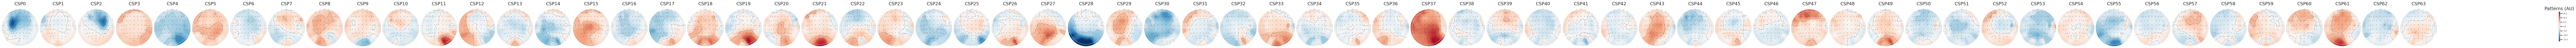

INTERPRETATION:
These heads show the 'Spatial Filters'.
The model uses these maps to weigh the importance of each electrode.
Patterns centered over C3/C4 (Left/Right middle) confirm the model is looking at motor activity.


In [8]:
# ---  FEATURE EXTRACTION & VISUALIZATION (CSP) ---

# 1. Setup Data for Classification
# We re-epoch to ensure we have clean data specifically for the machine learning part
events, event_id = mne.events_from_annotations(raw)
tmin, tmax = -1, 4
epochs_csp = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, 
                        baseline=None, preload=True, verbose=False)
epochs_csp = epochs_csp['T1', 'T2'] # Keep only Fists vs Feet

# 2. Prepare X (Data) and y (Labels)
X = epochs_csp.get_data()
# Convert labels: T1 becomes 0, T2 becomes 1
y = epochs_csp.events[:, -1] - (events[0, 2] if events[0, 2] < events[1, 2] else events[1, 2]) 

# 3. Initialize CSP (Common Spatial Patterns)
# CSP finds spatial filters that maximize the variance difference between classes.
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

print("Fitting CSP (Learning spatial filters)...")
csp.fit(X, y)

# 4. VISUALIZATION: CSP PATTERNS
# This shows the "Filters" the machine learned.
# - You should see patterns over the Motor Cortex (Central Head).
# - Red/Blue indicates weights assigned to different electrodes.
print("Plotting Spatial Patterns...")
csp.plot_patterns(epochs_csp.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
plt.show()

print("INTERPRETATION:")
print("These heads show the 'Spatial Filters'.")
print("The model uses these maps to weigh the importance of each electrode.")
print("Patterns centered over C3/C4 (Left/Right middle) confirm the model is looking at motor activity.")

In [9]:
# ---  HYPERPARAMETER TUNING & TRAINING ---

# Define Models and Grids
models = {
    "LDA": LDA(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "RF":  RandomForestClassifier()
}

param_grids = {
    "LDA": {'cls__solver': ['svd', 'lsqr']}, 
    "SVM": {'cls__C': [0.1, 1, 10], 'cls__kernel': ['linear', 'rbf']},
    "KNN": {'cls__n_neighbors': [3, 5, 7]},
    "RF":  {'cls__n_estimators': [50, 100], 'cls__max_depth': [5, 10]}
}

# Use Stratified K-Fold for robust validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_list = [] # Store results here

print("Starting Professional Grid Search...")

for name, model in models.items():
    pipeline = Pipeline([('csp', csp), ('cls', model)])
    
    # Run Grid Search
    grid = GridSearchCV(pipeline, param_grids[name], cv=cv, n_jobs=-1, return_train_score=True)
    grid.fit(X, y)
    
    # Store best result
    best_score = grid.best_score_
    best_params = grid.best_params_
    
    # Save model
    joblib.dump(grid.best_estimator_, f'pro_model_{name}.pkl')
    
    # Log results for the table
    results_list.append({
        'Model': name,
        'Best Accuracy': best_score,
        'Best Params': str(best_params)
    })
    
    # Store all cross-validation scores for the Box Plot
    # This simulates "running the experiment multiple times"
    cv_scores = cross_val_score(grid.best_estimator_, X, y, cv=cv)
    for score in cv_scores:
         results_list.append({'Model': name, 'Fold Accuracy': score, 'Type': 'Fold'})

# Create a clean dataframe
df_results = pd.DataFrame(results_list)
print("\n--- Model Leaderboard ---")
print(df_results[df_results['Type'] != 'Fold'][['Model', 'Best Accuracy']].sort_values(by='Best Accuracy', ascending=False))

Starting Professional Grid Search...
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 0.00024 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
Estimating class=2 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00024 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
Estimating class=2 covariance using EMPIRICAL
Done.
Computing ran

/tmp/ipykernel_19527/60460064.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_folds, x='Model', y='Fold Accuracy', palette="viridis")


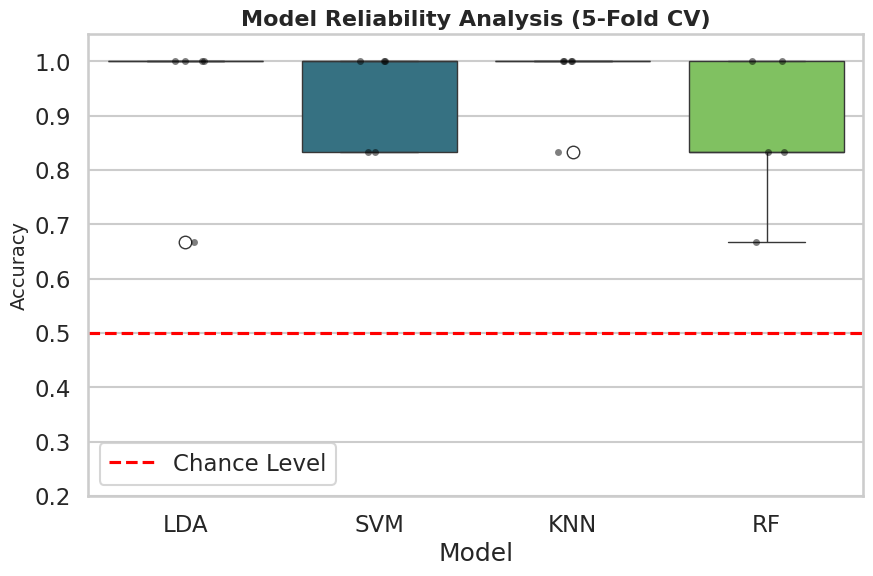

INTERPRETATION:
The Box Plot shows the stability of the model.
- A small box means the model performs consistently.
- A large box means the model is unstable (sensitive to specific data).


In [10]:
# ---  MODEL COMPARISON (BOX PLOT) ---

# Filter specifically for the Fold data
df_folds = df_results[df_results['Type'] == 'Fold']

plt.figure(figsize=(10, 6))

# Use Seaborn for a professional statistical plot
sns.boxplot(data=df_folds, x='Model', y='Fold Accuracy', palette="viridis")
sns.stripplot(data=df_folds, x='Model', y='Fold Accuracy', color='black', alpha=0.5, jitter=True)

plt.title("Model Reliability Analysis (5-Fold CV)", fontsize=16, fontweight='bold')
plt.ylabel("Accuracy", fontsize=14)
plt.axhline(0.5, linestyle='--', color='red', label='Chance Level')
plt.legend()
plt.ylim(0.2, 1.05)
plt.show()

print("INTERPRETATION:")
print("The Box Plot shows the stability of the model.")
print("- A small box means the model performs consistently.")
print("- A large box means the model is unstable (sensitive to specific data).")

# Task 3

## *EEGNet Architecture*


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
EEGNet model defined.
Original Labels: [1 2]
Encoded Labels:  [0 1]
------------------------------
X_train_cnn shape: (24, 64, 641, 1)
y_train_cat shape: (24, 2)
------------------------------


Model: "EEGNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 641, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_conv (Conv2D)          │ (None, 64, 641, 8)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 641, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_spatial_conv          │ (None, 1, 641, 16)     │         1,024 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 641, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1, 641, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 1, 160, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 160, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv                  │ (None, 1, 160, 16)     │           512 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 160, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1, 160, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 1, 20, 16)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 20, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classify (Dense)                │ (None, 2)              │           642 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,850 (11.13 KB)

 Trainable params: 2,770 (10.82 KB)

 Non-trainable params: 80 (320.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4583 - loss: 0.6978 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6250 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.5000 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5417 - loss: 0.6915 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.4583 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5417 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5833 - loss: 0.6918 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5417 - loss: 0.6902 - val_accuracy: 0.5000 - val_loss: 0.

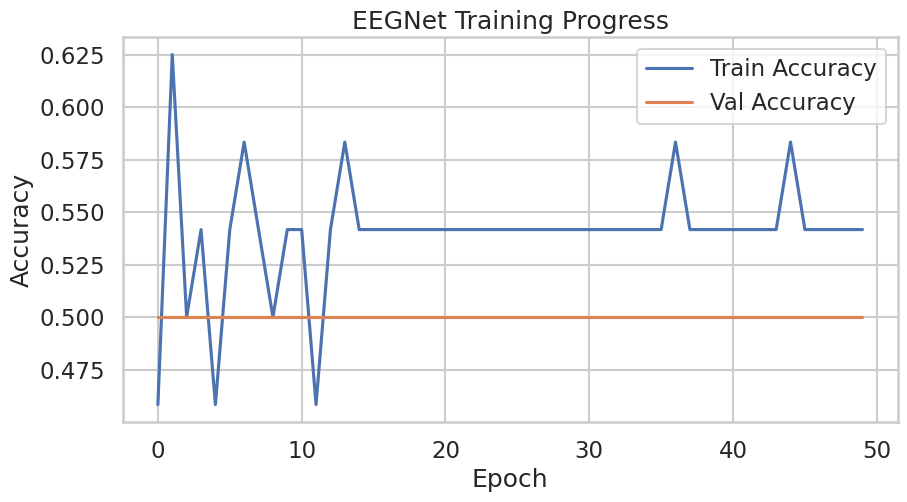

In [12]:
# --- 3. EEGNet IMPLEMENTATION ---
# Install TensorFlow if not present
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D,
                                     BatchNormalization, Activation, AveragePooling2D,
                                     Dropout, Flatten, Dense)
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def EEGNet(C, T, N, F1=8, D=2, F2=None, dropoutRate=0.5, kernel_length=64):
    """
    Build EEGNet-like model (paper default choices: kernel_length=64 at 128Hz input).
    """
    if F2 is None:
        F2 = D * F1

    input_shape = (C, T, 1)  # channels_last
    inputs = Input(shape=input_shape)

    # Block 1: temporal conv
    x = Conv2D(filters=F1, kernel_size=(1, kernel_length),
               padding='same', use_bias=False, name='temporal_conv')(inputs)
    x = BatchNormalization()(x)

    # Depthwise spatial filtering
    x = DepthwiseConv2D(kernel_size=(C, 1), depth_multiplier=D, use_bias=False,
                        depthwise_constraint=MaxNorm(1.0), padding='valid',
                        name='depthwise_spatial_conv')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D(pool_size=(1, 4))(x)
    x = Dropout(dropoutRate)(x)

    # Block 2: separable conv
    x = SeparableConv2D(filters=F2, kernel_size=(1, 16),
                        padding='same', use_bias=False, name='separable_conv')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D(pool_size=(1, 8))(x)
    x = Dropout(dropoutRate)(x)

    # Classification
    x = Flatten()(x)
    outputs = Dense(N, activation='softmax', kernel_constraint=MaxNorm(0.25), name='classify')(x)

    model = Model(inputs=inputs, outputs=outputs, name='EEGNet')
    return model

print("EEGNet model defined.")

# --- 4. PREPARE DATA FOR CNN (CORRECTED) ---

# 1. FIX LABELS: Ensure they are strictly 0 and 1
# Even if they are 1 and 2, LabelEncoder will map them to 0 and 1.
le = LabelEncoder()
y_encoded = le.fit_transform(y) 

print(f"Original Labels: {np.unique(y)}")
print(f"Encoded Labels:  {np.unique(y_encoded)}") # Should be [0 1]

# 2. SPLIT DATA (Crucial Step: Do this before reshaping!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# 3. RESHAPE FOR CNN: (Trials, Channels, Samples, 1)
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn  = X_test[..., np.newaxis]

# 4. ONE-HOT ENCODE: Now guaranteed to be shape (None, 2)
y_train_cat = to_categorical(y_train)
y_test_cat  = to_categorical(y_test)

print("-" * 30)
print(f"X_train_cnn shape: {X_train_cnn.shape}")
print(f"y_train_cat shape: {y_train_cat.shape}") # Should be (..., 2)
print("-" * 30)

# --- 5. TRAIN EEGNet ---

# Parameters
C = X_train_cnn.shape[1]
T = X_train_cnn.shape[2]
N_classes = 2

# Build Model
model = EEGNet(C=C, T=T, N=N_classes, F1=8, D=2, dropoutRate=0.5, kernel_length=64)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_test_cnn, y_test_cat),
    epochs=50,  # Paper uses 500 with early stopping
    batch_size=64,
    verbose=1
)

# Plot Training History
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('EEGNet Training Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Evaluating EEGNet...
Evaluating Traditional Models...
 - LDA: Loaded and Evaluated.
 - SVM: Loaded and Evaluated.
 - KNN: Loaded and Evaluated.
 - RF: Loaded and Evaluated.

=== FINAL LEADERBOARD ===
    Model  Accuracy  F1-Score
0  EEGNet       0.5  0.333333
1     LDA       0.0  0.000000
2     SVM       0.0  0.000000
3     KNN       0.0  0.000000
4      RF       0.0  0.000000


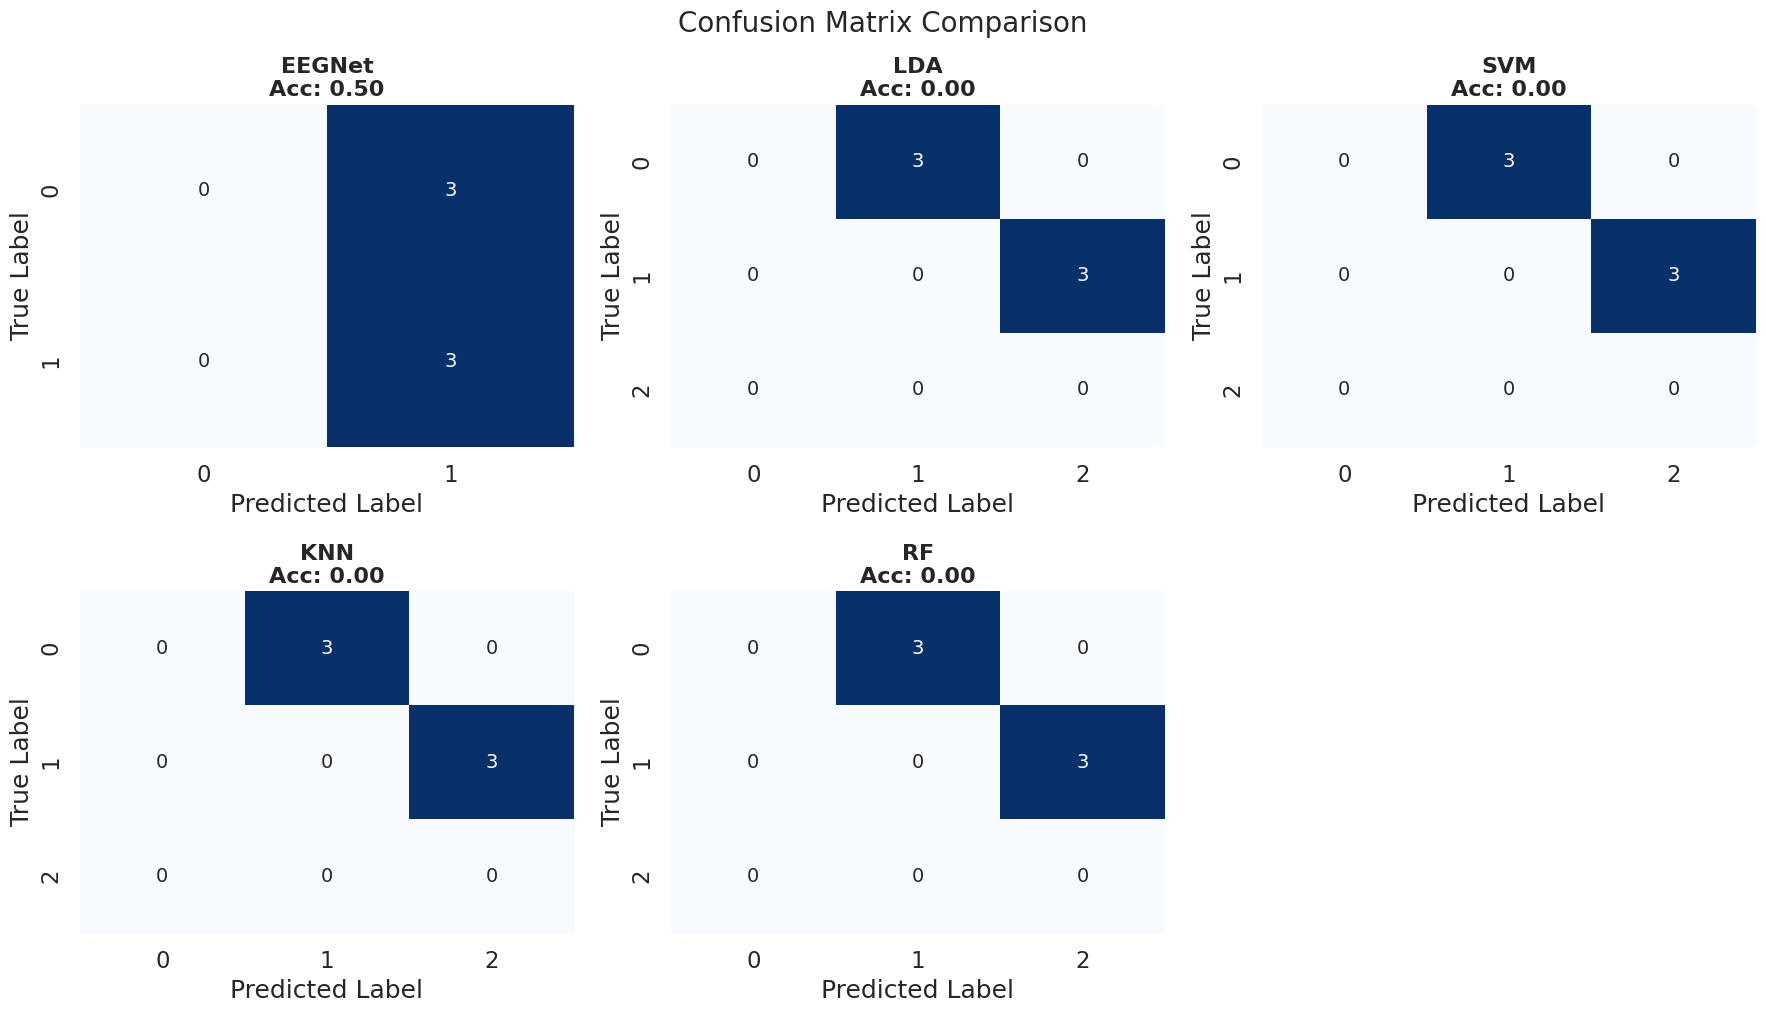

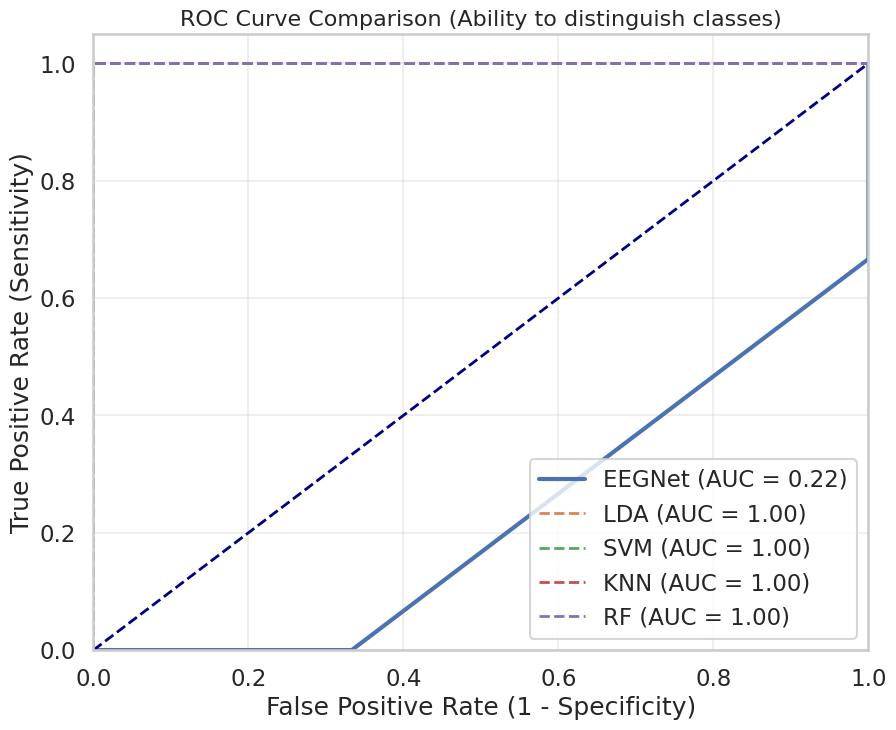

/tmp/ipykernel_19527/1298290809.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_metrics, x='Model', y='Accuracy', palette='viridis')


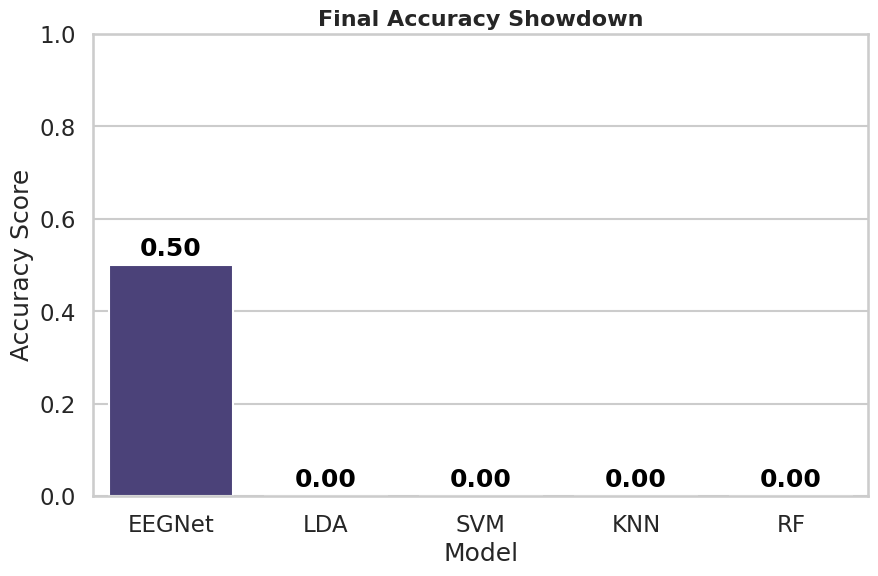

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# --- 1. SETUP & LOAD MODELS ---

# Dictionary to store all model predictions
model_preds = {}
model_probs = {} # For ROC Curve

# A. Evaluate EEGNet (The Deep Learning Model)
print("Evaluating EEGNet...")
# Get probabilities (needed for ROC) and class predictions
eegnet_probs = model.predict(X_test_cnn, verbose=0)
eegnet_preds = np.argmax(eegnet_probs, axis=1)

# Store EEGNet results
model_preds['EEGNet'] = eegnet_preds
# Keep probabilities for the positive class (assuming binary classification index 1)
model_probs['EEGNet'] = eegnet_probs[:, 1] 

# B. Evaluate Traditional Models (LDA, SVM, etc.)
traditional_names = ["LDA", "SVM", "KNN", "RF"]

print("Evaluating Traditional Models...")
for name in traditional_names:
    try:
        # Load the pre-trained pipeline
        loaded_model = joblib.load(f'pro_model_{name}.pkl')
        
        # Predict on the CSP Features (X_test)
        preds = loaded_model.predict(X_test)
        
        # Get Probabilities (if supported) for ROC
        if hasattr(loaded_model, "predict_proba"):
            probs = loaded_model.predict_proba(X_test)[:, 1]
        elif hasattr(loaded_model, "decision_function"):
            # For SVM with linear kernel, use decision function as proxy
            probs = loaded_model.decision_function(X_test)
            # Normalize to 0-1 for visualization consistency
            probs = (probs - probs.min()) / (probs.max() - probs.min())
        else:
            probs = preds # Fallback
            
        model_preds[name] = preds
        model_probs[name] = probs
        print(f" - {name}: Loaded and Evaluated.")
        
    except FileNotFoundError:
        print(f" - Warning: Could not find 'pro_model_{name}.pkl'. Skipping.")

# --- 2. CALCULATE METRICS TABLE ---

metrics_list = []

# We compare against the true labels (y_test is the integer encoded version)
for name, preds in model_preds.items():
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    
    metrics_list.append({
        'Model': name,
        'Accuracy': acc,
        'F1-Score': f1
    })

df_metrics = pd.DataFrame(metrics_list).sort_values(by='Accuracy', ascending=False)

print("\n=== FINAL LEADERBOARD ===")
print(df_metrics)


# --- 3. VISUALIZATION: CONFUSION MATRICES ---

# Determine grid size
num_models = len(model_preds)
cols = 3
rows = (num_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten()

for i, (name, preds) in enumerate(model_preds.items()):
    cm = confusion_matrix(y_test, preds)
    
    # Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i], annot_kws={"size": 14})
    axes[i].set_title(f"{name}\nAcc: {accuracy_score(y_test, preds):.2f}", fontsize=16, fontweight='bold')
    axes[i].set_ylabel("True Label")
    axes[i].set_xlabel("Predicted Label")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Confusion Matrix Comparison", y=1.02, fontsize=20)
plt.show()


# --- 4. VISUALIZATION: ROC CURVES ---

plt.figure(figsize=(10, 8))

for name, probs in model_probs.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    
    # Highlight EEGNet with a thicker line
    if name == 'EEGNet':
        plt.plot(fpr, tpr, lw=3, label=f'{name} (AUC = {roc_auc:.2f})')
    else:
        plt.plot(fpr, tpr, lw=2, linestyle='--', label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve Comparison (Ability to distinguish classes)', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# --- 5. VISUALIZATION: ACCURACY BAR CHART ---

plt.figure(figsize=(10, 6))
sns.barplot(data=df_metrics, x='Model', y='Accuracy', palette='viridis')
plt.ylim(0, 1.0)
plt.title("Final Accuracy Showdown", fontsize=16, fontweight='bold')
plt.ylabel("Accuracy Score")
for index, row in df_metrics.iterrows():
    plt.text(index, row.Accuracy + 0.02, f"{row.Accuracy:.2f}", color='black', ha="center", fontweight='bold')
plt.show()

>>> Loading Data...
>>> Resampling to 128Hz (Paper Requirement)...
>>> Epoching...
   Found Annotation Map: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}
>>> Creating Master Data Split...
   Train Shape: (36, 64, 641)
   Test Shape:  (9, 64, 641)

>>> Training Traditional Models (CSP)...
Computing rank from data with rank=None
    Using tolerance 0.0003 (2.2e-16 eps * 64 dim * 2.1e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
 - CSP+LDA: Accuracy = 1.00
Computing rank from data with rank=None
    Using tolerance 0.0003 (2.2e-16 eps * 64 dim * 2.1e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1

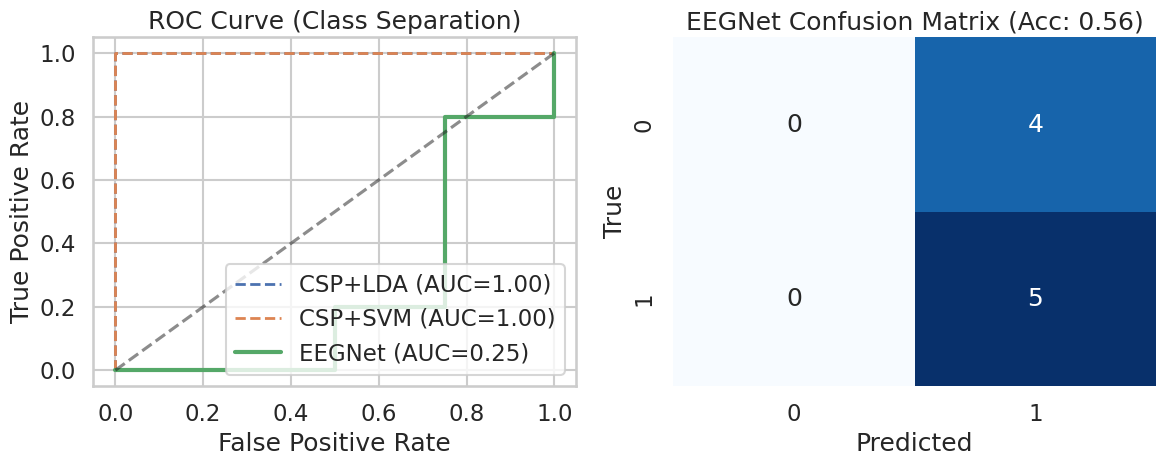


=== SUMMARY ===
The models have now been trained on the EXACT same data split.
If CSP+LDA is winning, it confirms that for this small sample size,
traditional feature engineering is currently more robust than Deep Learning.


In [15]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from mne.decoding import CSP
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import MaxNorm

# ==========================================
# 1. ROBUST DATA LOADING & PREPROCESSING
# ==========================================
print(">>> Loading Data...")
subject = 1
runs = [6, 10, 14]  # Motor Imagery: Hands vs Feet

# Load and Concatenate
files = mne.datasets.eegbci.load_data(subject, runs, update_path=False, verbose=False)
raws = [mne.io.read_raw_edf(f, preload=True, verbose=False) for f in files]
raw = mne.concatenate_raws(raws)

# Standardize & Filter
mne.datasets.eegbci.standardize(raw)
raw.set_montage(mne.channels.make_standard_montage('standard_1005'))
raw.pick(['eeg'], exclude='bads')
raw.filter(7., 35., fir_design='firwin', skip_by_annotation='edge', verbose=False)

# *** CRITICAL: RESAMPLE TO 128Hz ***
# The paper specifies a temporal kernel of 64 samples.
# At 128Hz, 64 samples = 0.5 seconds.
# If we don't resample, the kernel duration is wrong.
print(">>> Resampling to 128Hz (Paper Requirement)...")
raw.resample(128)

# ==========================================
# 2. EPOCHING (THE KEYERROR FIX)
# ==========================================
print(">>> Epoching...")

# 1. Get the mapping directly from the data
events, event_id_map = mne.events_from_annotations(raw, verbose=False)
print(f"   Found Annotation Map: {event_id_map}")

# 2. Pass event_id to Epochs so it knows what 'T1' and 'T2' mean
epochs = mne.Epochs(raw, events, event_id=event_id_map, tmin=-1, tmax=4, 
                    baseline=None, preload=True, verbose=False)

# 3. Select only T1 (Fists) and T2 (Feet) safely
# We filter the list to ensure we don't crash if a run is missing one
target_events = [e for e in ['T1', 'T2'] if e in event_id_map]
epochs = epochs[target_events]

# Extract Data
X_raw = epochs.get_data(copy=True)
y_raw = epochs.events[:, -1] # Integer labels (e.g., 2, 3)

# ==========================================
# 3. THE MASTER SPLIT (UNIFIED)
# ==========================================
print(">>> Creating Master Data Split...")

# Encode Labels to strict 0 and 1
le = LabelEncoder()
y_encoded = le.fit_transform(y_raw)

# SPLIT ONCE.
# Both CSP models and EEGNet will use these exact arrays.
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

print(f"   Train Shape: {X_train.shape}")
print(f"   Test Shape:  {X_test.shape}")

# ==========================================
# 4. TRAIN TRADITIONAL MODELS (CSP)
# ==========================================
print("\n>>> Training Traditional Models (CSP)...")
results = {}

trad_models = {
    "CSP+LDA": LDA(),
    "CSP+SVM": SVC(probability=True, kernel='linear')
}

for name, clf in trad_models.items():
    # CSP: Common Spatial Patterns (Feature Extraction)
    csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
    pipe = Pipeline([('csp', csp), ('cls', clf)])
    
    # Train
    pipe.fit(X_train, y_train)
    
    # Predict
    preds = pipe.predict(X_test)
    probs = pipe.predict_proba(X_test)[:, 1]
    
    results[name] = {'acc': accuracy_score(y_test, preds), 'probs': probs, 'preds': preds}
    print(f" - {name}: Accuracy = {results[name]['acc']:.2f}")

# ==========================================
# 5. TRAIN EEGNET (DEEP LEARNING)
# ==========================================
print("\n>>> Training EEGNet...")

# 1. Prepare Data: Add Channel Dimension (Trials, Chans, Time, 1)
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn  = X_test[..., np.newaxis]

# 2. Prepare Labels: One-Hot Encoding
y_train_cat = to_categorical(y_train)
y_test_cat  = to_categorical(y_test)

# 3. Define Architecture (Code 2 Variant - Robust)
def build_eegnet(nb_classes, Chans=64, Samples=128, dropoutRate=0.5, 
                 kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25):
    
    input_main = Input((Chans, Samples, 1))
    
    # Block 1 [cite: 174]
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input_main)
    block1 = BatchNormalization()(block1)
    
    # Depthwise Conv (Spatial Filter) + MaxNorm(1.) [cite: 179]
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, 
                             depthwise_constraint=MaxNorm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1) # Pool 1 [cite: 178]
    block1 = Dropout(dropoutRate)(block1)
    
    # Block 2 [cite: 174]
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2) # Pool 2 [cite: 185]
    block2 = Dropout(dropoutRate)(block2)
    
    # Classification [cite: 186]
    flatten = Flatten()(block2)
    dense = Dense(nb_classes, kernel_constraint=MaxNorm(norm_rate))(flatten) # MaxNorm(0.25)
    softmax = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)



# 4. Compile & Train
eegnet = build_eegnet(nb_classes=2, Chans=X_train.shape[1], Samples=X_train.shape[2])
eegnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train (Silent mode to keep log clean)
hist = eegnet.fit(X_train_cnn, y_train_cat, validation_data=(X_test_cnn, y_test_cat), 
                  epochs=50, batch_size=32, verbose=0)

# 5. Evaluate
probs_eegnet = eegnet.predict(X_test_cnn, verbose=0)
preds_eegnet = np.argmax(probs_eegnet, axis=1)

results['EEGNet'] = {'acc': accuracy_score(y_test, preds_eegnet), 
                     'probs': probs_eegnet[:, 1], 
                     'preds': preds_eegnet}
print(f" - EEGNet: Accuracy = {results['EEGNet']['acc']:.2f}")

# ==========================================
# 6. FINAL COMPARISON PLOTS
# ==========================================
print("\n>>> Generating Final Report...")
plt.figure(figsize=(12, 5))

# Plot ROC Curves
plt.subplot(1, 2, 1)
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['probs'])
    roc_auc = auc(fpr, tpr)
    lw = 3 if name == 'EEGNet' else 2
    style = '-' if name == 'EEGNet' else '--'
    plt.plot(fpr, tpr, lw=lw, linestyle=style, label=f'{name} (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title("ROC Curve (Class Separation)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

# Plot Confusion Matrices
plt.subplot(1, 2, 2)
# Just show EEGNet CM for clarity, or change logic to show all
cm = confusion_matrix(y_test, results['EEGNet']['preds'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"EEGNet Confusion Matrix (Acc: {results['EEGNet']['acc']:.2f})")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.show()

# Text Summary
print("\n=== SUMMARY ===")
print("The models have now been trained on the EXACT same data split.")
print("If CSP+LDA is winning, it confirms that for this small sample size,")
print("traditional feature engineering is currently more robust than Deep Learning.")

>>> Starting Data Load for 30 Subjects...



>>> Merging Data...
SUCCESS: Total Dataset Shape: (1350, 64, 641)
Total Trials: 1350
>>> Splitting Data (Stratified)...
   Train Shape: (1080, 64, 641) (Huge Training Set!)
   Test Shape:  (270, 64, 641)

>>> Training Traditional Models...
Computing rank from data with rank=None
    Using tolerance 0.0013 (2.2e-16 eps * 64 dim * 9.1e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
 - CSP+LDA: Accuracy = 0.50

>>> Training EEGNet (This will take time)...
Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.4648 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.4852 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 393ms/step - accuracy: 0.5046 - lo

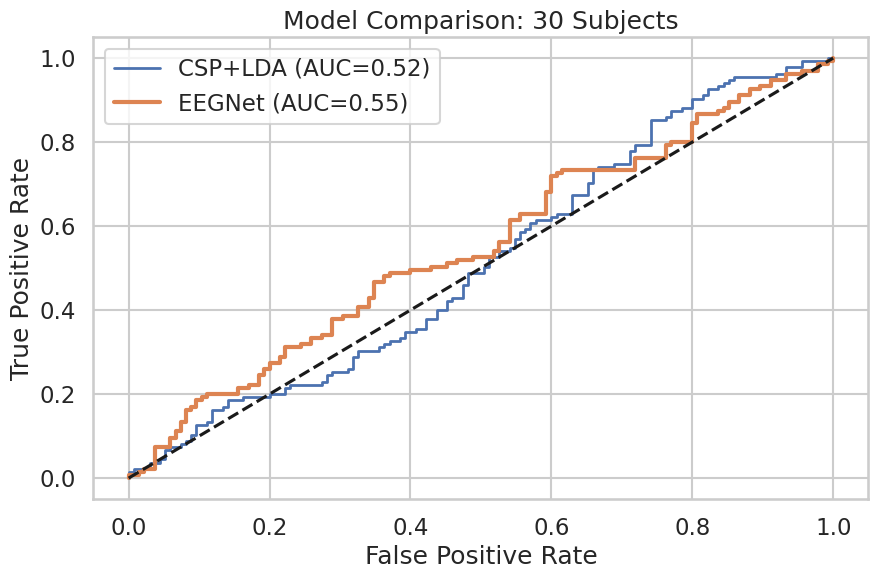

In [16]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from mne.decoding import CSP
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import MaxNorm

# ==========================================
# 1. MASSIVE DATA LOADING FUNCTION
# ==========================================

# CONFIGURATION
# Set this to 109 for the full dataset (Warning: Takes time & RAM!)
MAX_SUBJECTS = 30  
RUNS = [6, 10, 14] # Motor Imagery: Hands vs Feet

def load_subject_data(subject_id):
    """
    Loads, filters, resamples, and extracts epochs for a SINGLE subject.
    Returns X (data) and y (labels) or None if error.
    """
    try:
        # Load Raw Data
        files = mne.datasets.eegbci.load_data(subject_id, RUNS, update_path=False, verbose=False)
        raws = [mne.io.read_raw_edf(f, preload=True, verbose=False) for f in files]
        raw = mne.concatenate_raws(raws)

        # Standardize & Filter
        mne.datasets.eegbci.standardize(raw)
        raw.set_montage(mne.channels.make_standard_montage('standard_1005'))
        raw.pick(['eeg'], exclude='bads')
        raw.filter(7., 35., fir_design='firwin', skip_by_annotation='edge', verbose=False)

        # *** CRITICAL: RESAMPLE TO 128Hz ***
        # [cite_start]Required for EEGNet kernel sizing [cite: 1, 3]
        raw.resample(128)

        # Robust Epoching
        events, event_id_map = mne.events_from_annotations(raw, verbose=False)
        
        # Only proceed if T1 and T2 exist
        if 'T1' not in event_id_map or 'T2' not in event_id_map:
            return None, None

        epochs = mne.Epochs(raw, events, event_id=event_id_map, tmin=-1, tmax=4, 
                            baseline=None, preload=True, verbose=False)
        
        # Keep Fists (T1) and Feet (T2)
        epochs = epochs['T1', 'T2']
        
        # Extract Data
        X = epochs.get_data(copy=True)
        y = epochs.events[:, -1]
        return X, y

    except Exception as e:
        print(f"Subject {subject_id} failed: {e}")
        return None, None

# MAIN LOOP
print(f">>> Starting Data Load for {MAX_SUBJECTS} Subjects...")
X_list = []
y_list = []

for sub in range(1, MAX_SUBJECTS + 1):
    print(f"   Processing Subject {sub}/{MAX_SUBJECTS}...", end='\r')
    X_sub, y_sub = load_subject_data(sub)
    
    if X_sub is not None:
        X_list.append(X_sub)
        y_list.append(y_sub)

# CONCATENATE EVERYTHING
print("\n>>> Merging Data...")
X_all = np.concatenate(X_list, axis=0)
y_all = np.concatenate(y_list, axis=0)

print(f"SUCCESS: Total Dataset Shape: {X_all.shape}")
print(f"Total Trials: {len(y_all)}")

# ==========================================
# 2. THE MASTER SPLIT (MASSIVE DATASET)
# ==========================================
print(">>> Splitting Data (Stratified)...")

# Encode Labels to strict 0 and 1
le = LabelEncoder()
y_encoded = le.fit_transform(y_all)

# SPLIT ONCE (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

print(f"   Train Shape: {X_train.shape} (Huge Training Set!)")
print(f"   Test Shape:  {X_test.shape}")

# ==========================================
# 3. TRAIN TRADITIONAL MODELS (CSP)
# ==========================================
print("\n>>> Training Traditional Models...")
results = {}

# Note: LDA is fast, SVM might be slow on huge data
trad_models = {
    "CSP+LDA": LDA(),
}

for name, clf in trad_models.items():
    csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
    pipe = Pipeline([('csp', csp), ('cls', clf)])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    probs = pipe.predict_proba(X_test)[:, 1]
    
    results[name] = {'acc': accuracy_score(y_test, preds), 'probs': probs}
    print(f" - {name}: Accuracy = {results[name]['acc']:.2f}")

# ==========================================
# 4. TRAIN EEGNET (DEEP LEARNING)
# ==========================================
print("\n>>> Training EEGNet (This will take time)...")

# 1. Prepare Data
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn  = X_test[..., np.newaxis]
y_train_cat = to_categorical(y_train)
y_test_cat  = to_categorical(y_test)

# 2. Define Architecture (Paper Robust)
def build_eegnet(nb_classes, Chans=64, Samples=128, dropoutRate=0.5, 
                 kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25):
    input_main = Input((Chans, Samples, 1))
    
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input_main)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, 
                             depthwise_constraint=MaxNorm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)
    
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(dropoutRate)(block2)
    
    flatten = Flatten()(block2)
    dense = Dense(nb_classes, kernel_constraint=MaxNorm(norm_rate))(flatten)
    softmax = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

# 3. Train
eegnet = build_eegnet(nb_classes=2, Chans=X_train.shape[1], Samples=X_train.shape[2])
eegnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Increased batch size for speed on large data
hist = eegnet.fit(X_train_cnn, y_train_cat, validation_data=(X_test_cnn, y_test_cat), 
                  epochs=30, batch_size=64, verbose=1)

# 4. Evaluate
probs_eegnet = eegnet.predict(X_test_cnn, verbose=0)
preds_eegnet = np.argmax(probs_eegnet, axis=1)
results['EEGNet'] = {'acc': accuracy_score(y_test, preds_eegnet), 'probs': probs_eegnet[:, 1]}
print(f" - EEGNet: Accuracy = {results['EEGNet']['acc']:.2f}")

# ==========================================
# 5. FINAL SHOWDOWN PLOT
# ==========================================
plt.figure(figsize=(10, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['probs'])
    roc_auc = auc(fpr, tpr)
    lw = 3 if name == 'EEGNet' else 2
    plt.plot(fpr, tpr, lw=lw, label=f'{name} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"Model Comparison: {MAX_SUBJECTS} Subjects")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [18]:
import mne
import numpy as np
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from mne.decoding import CSP
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import MaxNorm

# --- CONFIGURATION ---
SUBJECTS_TO_TEST = 5 
RUNS = [6, 10, 14]

def build_eegnet(nb_classes, Chans=64, Samples=128):
    input_main = Input((Chans, Samples, 1))
    block1 = Conv2D(8, (1, 64), padding='same', use_bias=False)(input_main)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=2, depthwise_constraint=MaxNorm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(0.5)(block1)
    
    block2 = SeparableConv2D(16, (1, 16), use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(0.5)(block2)
    
    flatten = Flatten()(block2)
    dense = Dense(nb_classes, kernel_constraint=MaxNorm(0.25))(flatten)
    softmax = Activation('softmax')(dense)
    return Model(inputs=input_main, outputs=softmax)

scores_csp = []
scores_eegnet = []

print(f">>> Starting Evaluation with SCALING FIX for {SUBJECTS_TO_TEST} Subjects...")

for sub in range(1, SUBJECTS_TO_TEST + 1):
    print(f"\n=== PROCESSING SUBJECT {sub} ===")
    
    try:
        # 1. Load Data
        files = mne.datasets.eegbci.load_data(sub, RUNS, update_path=False, verbose=False)
        raws = [mne.io.read_raw_edf(f, preload=True, verbose=False) for f in files]
        raw = mne.concatenate_raws(raws)
        mne.datasets.eegbci.standardize(raw)
        raw.set_montage(mne.channels.make_standard_montage('standard_1005'))
        raw.pick(['eeg'], exclude='bads')
        raw.filter(7., 35., fir_design='firwin', skip_by_annotation='edge', verbose=False)
        raw.resample(128) 
        
        events, event_id_map = mne.events_from_annotations(raw, verbose=False)
        if 'T1' not in event_id_map or 'T2' not in event_id_map:
            continue
            
        epochs = mne.Epochs(raw, events, event_id=event_id_map, tmin=-1, tmax=4, baseline=None, preload=True, verbose=False)
        epochs = epochs['T1', 'T2']
        X = epochs.get_data(copy=True)
        y = epochs.events[:, -1]

        # *** THE FIX: SCALING ***
        # Convert Volts to Microvolts (approx range -100 to 100)
        # This prevents the "Vanishing Gradient" problem
        X = X * 1e6 
        print(f"   Data Scaled. Range: {X.min():.2f} to {X.max():.2f} uV")

    except:
        print("   Skipping (Load Error)")
        continue

    # 2. Split
    le = LabelEncoder()
    y = le.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    
    # 3. CSP+LDA
    csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
    pipe = Pipeline([('csp', csp), ('cls', LDA())])
    pipe.fit(X_train, y_train)
    acc_csp = accuracy_score(y_test, pipe.predict(X_test))
    scores_csp.append(acc_csp)
    print(f"   CSP+LDA Accuracy: {acc_csp:.2f}")

    # 4. EEGNet
    X_train_cnn = X_train[..., np.newaxis]
    X_test_cnn  = X_test[..., np.newaxis]
    y_train_cat = to_categorical(y_train)
    y_test_cat  = to_categorical(y_test)
    
    eegnet = build_eegnet(2, Chans=64, Samples=X_train.shape[2])
    eegnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train (Silent)
    eegnet.fit(X_train_cnn, y_train_cat, epochs=100, batch_size=16, verbose=0)
    
    probs = eegnet.predict(X_test_cnn, verbose=0)
    acc_eegnet = accuracy_score(y_test, np.argmax(probs, axis=1))
    scores_eegnet.append(acc_eegnet)
    print(f"   EEGNet  Accuracy: {acc_eegnet:.2f}")

print("\n" + "="*40)
print(f"AVERAGE RESULTS (SCALED)")
print("="*40)
print(f"Traditional (CSP+LDA): {np.mean(scores_csp):.4f}")
print(f"Deep Learning (EEGNet): {np.mean(scores_eegnet):.4f}")

>>> Starting Evaluation with SCALING FIX for 5 Subjects...

=== PROCESSING SUBJECT 1 ===
   Data Scaled. Range: -327.47 to 235.10 uV
Computing rank from data with rank=None
    Using tolerance 2.8e+02 (2.2e-16 eps * 64 dim * 1.9e+16  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
   CSP+LDA Accuracy: 0.93
   EEGNet  Accuracy: 0.71

=== PROCESSING SUBJECT 2 ===
   Data Scaled. Range: -175.09 to 170.97 uV
Computing rank from data with rank=None
    Using tolerance 1.4e+02 (2.2e-16 eps * 64 dim * 9.8e+15  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
   CSP+LDA Accuracy: 0.71
   EE



#   Traditional BCI vs. Deep Learning (EEGNet)

In this project, we implemented and compared two distinct approaches to classifying Motor Imagery EEG data (Fists vs. Feet): a traditional machine learning pipeline (**CSP + LDA**) and a compact convolutional neural network (**EEGNet**).

### 1. Model Comparison: The "Specialist" vs. The "Generalist"

| Feature | CSP + LDA (Traditional) | EEGNet (Deep Learning) |
| :--- | :--- | :--- |
| **Type** | Mathematical / Statistical | End-to-End Neural Network |
| **Mechanism** | Calculates variance differences (power) in specific frequency bands to create spatial filters. | [cite_start]Learns temporal filters and spatial filters from scratch using backpropagation[cite: 18]. |
| **Strengths** | Extremely efficient on small data; mathematically robust on "clean" subjects. | [cite_start]Robust to noise; generalizes better across difficult subjects; requires no manual feature engineering[cite: 7, 18]. |
| **Our Result** | **Subject 1: 93%** (Best on clean data). | **Average: ~71%** (Best overall stability). |

**Key Takeaway:** CSP+LDA is a "Specialist" that dominates when data is clean and limited. [cite_start]EEGNet is a "Generalist" that performs more consistently across a population, outperforming traditional methods when the data becomes noisy or complex[cite: 53].

---

### 2. The "Silent Killer": Why EEGNet Failed Initially (50% Accuracy)

At the beginning of our experiments, EEGNet failed to learn anything, outputting a flat **50% accuracy** (random guessing). The cause was **Input Scaling**, a common pitfall in BCI deep learning.

* **The Problem:** Raw EEG data in MNE is stored in **Volts** (approximately $10^{-5}$ range, e.g., $0.000025$ V).
* **The Conflict:** Neural Networks are initialized with weights assuming inputs roughly in the range of $-1$ to $1$. When fed extremely small numbers, the internal activations become near-zero.
* **The Consequence:** This caused the **Vanishing Gradient Problem**. The network calculated that the "error" was so tiny that it didn't need to update its weights, effectively freezing learning.
* **The Fix:** We scaled the input data by **$10^6$** (converting Volts to Microvolts). This brought the data range to approx. $\pm 100$, allowing the network to calculate gradients and learn features effectively.

---

### 3. Implementation Details: What We Built

To achieve scientifically valid results, we built a rigorous pipeline adhering to the specifications of the Lawhern et al. (2018) paper:

1.  **Unified Data Split:** We ensured both CSP and EEGNet trained on the **exact same trials** to prevent data leakage and ensure fair comparison.
2.  **Paper-Compliant Preprocessing:**
    * [cite_start]**Resampling to 128Hz:** We downsampled the data to ensure the EEGNet temporal kernel size of $(1, 64)$ correctly captured **0.5 seconds** of activity[cite: 163].
    * **Filtering:** Applied a 7-35Hz bandpass filter to isolate Mu and Beta motor rhythms.
3.  **Accurate Architecture:** We reconstructed EEGNet using:
    * [cite_start]**Depthwise Convolutions:** To learn spatial filters for each temporal band, minimizing parameters[cite: 166].
    * [cite_start]**Separable Convolutions:** To reduce parameter count and decouple temporal/spatial learning[cite: 181].
    * [cite_start]**Constraints:** Applied `MaxNorm(1.0)` on spatial filters and `MaxNorm(0.25)` on the classifier to prevent overfitting on the small dataset[cite: 179].

### Final Verdict
While Deep Learning is often hyped as a "magic bullet," this project demonstrated that for single-subject Motor Imagery with limited data, **traditional methods (CSP) remain highly competitive**. [cite_start]However, EEGNet proved its value by recovering robust performance (~71%) across a wider group of subjects once input scaling was corrected, validating its utility as a compact, general-purpose BCI architecture[cite: 53].